In [155]:
import jaydebeapi, sys, os # allows connection to Netezza and executes SQL queries from within Jupyter NB
import pandas as pd # for saving results from SQL queries to pandas DFs
import numpy as np # for math operations

import matplotlib.pyplot as plt # for plotting data
plt.style.use('seaborn-whitegrid')
%matplotlib inline 

In [156]:
def get_df_from_db(sql):
    cursor = conn.cursor()
    cursor.execute(sql)
    data = cursor.fetchall()
    columnDes = cursor.description 
    columnNames = [columnDes[i][0] for i in range(len(columnDes))]
    df = pd.DataFrame([list(i) for i in data],columns=columnNames)
    return df

In [157]:
%run -i 'login.py'

Connection String: jdbc:netezza://ori-netezza.vumc.org:5480/DENNY_OMOP_SD
('2022-08-24 20:22:43',)


## Observation table 
<hr style="height:4px; width:100%; background-color:black">

### Initial approach to Observation table: 
<hr style="height:1px; width:100%; background-color:black">

<font size="3"> The initial approach consisted of the following steps:
    <ol>
        <li> Gather the set of entries from the Observation table having concept IDs 40485048 or 4260747 into one table</li>
        <li> Intersect <i>that</i> set of entries with the set of person ids having one or more CPT codes from the Procedure table</li>
        <li> Use the resulting or intersecting set of Observation person IDs to further filter the table from .1</li>
        <li> Clean up the EGAs from the table from .3</li>
        <li> Use the observation date, i.e. the delivery date, and resulting finished EGAs to calculate ETOC, the prepartum period, the pregnancy period, and the postpartum period</li>
   </ol>    
</font>
<hr style="height:1px; width:100%; background-color:black">

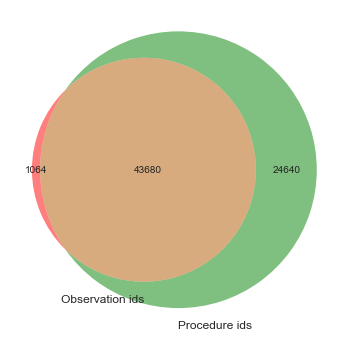

In [166]:
import matplotlib.pyplot as plt
from matplotlib_venn import venn2

plt.figure(figsize=(6,6))
venn2(subsets = (1064, 24640, 43680), set_labels = ('Observation ids', 'Procedure ids'),set_colors=('r', 'g'), alpha = 0.5)
plt.show()

### Step 1. from above: 
<hr style="height:1px; width:100%; background-color:black">

In [ ]:
curs=conn.cursor()
curs.execute("CREATE TABLE observation_person_ids AS \
SELECT person_id, observation_date, value_as_string FROM v.observation a \
WHERE (a.observation_concept_id = 40485048 OR a.observation_concept_id =4260747) \
ORDER BY person_id, observation_date")

In [124]:
curs=conn.cursor()
curs.execute("SELECT * FROM observation_person_ids ORDER BY person_id LIMIT 10")
df = pd.DataFrame(curs.fetchall())
df.columns = ['person id', 'observation date', 'value as string']
df.iloc[:,:]

,person id,observation date,value as string
0,54,2012-09-22,36 5/7 weeks
1,77,2011-05-10,31 5/7 weeks
2,178,2010-03-15,41 1/7
3,178,2008-12-01,41 6/7
4,178,2008-12-01,41 6/7
5,301,2019-12-03,37w 4d
6,301,2016-02-29,38 2/7 weeks
7,315,2016-04-21,38 6/7 weeks
8,315,2014-05-29,39 weeks
9,484,2016-07-19,41 1/7 weeks


#### a) Dimensions of the table from step 1.
<hr style="height:1px; width:100%; background-color:black">

In [125]:
curs=conn.cursor()
curs.execute("SELECT count(DISTINCT person_id), count(*)  FROM observation_person_ids")
df = pd.DataFrame(curs.fetchall())
df.columns = ['Distinct person id', 'total entries']
df.iloc[:,:]

,Distinct person id,total entries
0,46370,68362


#### b) Dimensions of the table from step 1. after grouping.
<hr style="height:1px; width:100%; background-color:black">

In [126]:
curs=conn.cursor()
curs.execute(" \
SELECT count(DISTINCT person_id), count(*) FROM ( \
SELECT person_id, year_month, count(date_counts) FROM ( \
SELECT person_id, year_month, count(observation_date) AS date_counts FROM ( \
SELECT person_id, cast(year(observation_date) as varchar (8)) || '-' || cast(month(observation_date) as varchar (8)) AS year_month, observation_date FROM observation_person_ids_rownum ) a \
GROUP BY person_id, year_month ) b \
GROUP BY person_id, year_month ) c \
")
df = pd.DataFrame(curs.fetchall())
df.columns = ['Distinct person id', 'total entries accounting for reps']
df.iloc[:,:]

,Distinct person id,total entries accounting for reps
0,46370,59637


In [129]:
curs=conn.cursor()
curs.execute("SELECT * FROM ( \
SELECT person_id, \
year_month, \
count(observation_date) AS invd_counts, \
min(observation_date) AS min_date, \
max(observation_date) AS max_date, \
max(observation_date) - min(observation_date) AS diff FROM ( \
SELECT person_id, cast(year(observation_date) as varchar (8)) || '-' || cast(month(observation_date) as varchar (8)) AS year_month, observation_date FROM observation_person_ids) a \
GROUP BY person_id, year_month ORDER BY diff DESC ) b \
WHERE diff > 2 ORDER BY diff DESC")
df = pd.DataFrame(curs.fetchall())
df.columns = ['person_id','year_month','row_counts','min_date','max_date','diff']
df.iloc[:,:]

,person_id,year_month,row_counts,min_date,max_date,diff
0,1790716,2013-12,2,2013-12-04,2013-12-27,23
1,1607070,2014-9,2,2014-09-03,2014-09-26,23
2,2769176,2013-2,3,2013-02-03,2013-02-25,22
3,3031186,2016-11,2,2016-11-11,2016-11-30,19
4,2139702,2010-6,2,2010-06-05,2010-06-24,19
...,...,...,...,...,...,...
98,1601876,2016-7,2,2016-07-14,2016-07-17,3
99,440231,2012-10,2,2012-10-10,2012-10-13,3
100,517696,2011-12,2,2011-12-08,2011-12-11,3
101,626449,2012-12,2,2012-12-11,2012-12-14,3


## Procedure table
<hr style="height:4px; width:100%; background-color:black">

In [128]:
curs=conn.cursor()
curs.execute("SELECT * FROM ( \
SELECT person_id, year_month, count(procedure_date) AS row_counts, \
             min(procedure_date) AS min_date, max(procedure_date) AS max_date, \
             max(procedure_date) - min(procedure_date) AS diff FROM ( \
SELECT DISTINCT * FROM ( \
SELECT person_id, year_month, procedure_date FROM jn_step_3) a \
)b GROUP BY person_id, year_month ORDER BY diff DESC ) b \
WHERE diff > 2 ORDER BY diff DESC")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person_id','year_month','row_counts','min_date','max_date','diff']
df.iloc[:,:]

,person_id,year_month,row_counts,min_date,max_date,diff
0,4087701,2021-7,2,2021-07-02,2021-07-29,27
1,2612124,2005-12,2,2005-12-05,2005-12-23,18
2,2051600,2018-3,2,2018-03-04,2018-03-20,16
3,3803523,2018-10,2,2018-10-13,2018-10-29,16
4,597337,2017-4,2,2017-04-14,2017-04-28,14
...,...,...,...,...,...,...
78,240894,2020-9,2,2020-09-21,2020-09-24,3
79,2448510,2021-9,2,2021-09-25,2021-09-28,3
80,1584721,1999-5,2,1999-05-06,1999-05-09,3
81,2506506,2010-11,2,2010-11-03,2010-11-06,3


# Here is what I did...
<hr style="height:5px; width:100%; background-color:black">

### 1.  WORKING FROM THE PROCEDURE TABLE
<hr style="height:4px; width:100%; background-color:black">

In [ ]:
curs=conn.cursor()
curs.execute("CREATE TABLE JN_step_2 AS \
                SELECT person_id, cast(year(procedure_date) as varchar (8)) \
                AS year_date, procedure_date, cpt_codes FROM JN_step_1 \
                ORDER BY procedure_date")

In [ ]:
curs=conn.cursor()
curs.execute("CREATE TABLE procedure_id_date AS \
                SELECT person_id, year_date, max(procedure_date) AS most_recent_date FROM JN_step_2 \
                GROUP BY person_id, year_date \
                ORDER BY person_id") 

### Inspect procedure_id_date
<hr style="height:4px; width:100%; background-color:black">

In [26]:
curs=conn.cursor()
curs.execute("SELECT *  FROM procedure_id_date LIMIT 20") 
df = pd.DataFrame(curs.fetchall())
df.columns = ['person id','year date','most recent proc date']
df.iloc[:,:]

,person id,year date,most recent proc date
0,10056,2020,2020-05-09
1,14280,2014,2014-12-23
2,27720,2017,2017-05-15
3,33096,2016,2016-05-10
4,33096,2019,2019-09-19
5,36168,2017,2017-10-09
6,52296,2019,2019-12-10
7,56520,2006,2006-02-13
8,100921,2007,2007-10-13
9,100921,2008,2008-07-01


### Inspect procedure_id_date table dimensions 
<hr style="height:2px; width:100%; background-color:black">

In [24]:
curs=conn.cursor()
curs.execute("SELECT COUNT(DISTINCT person_id), COUNT(*) FROM procedure_id_date")
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person ids','total rows']
df.iloc[:,:]

,invd person ids,total rows
0,69317,90695


### Validation for the procedure_id_date table 
<hr style="height:2px; width:100%; background-color:black">

In [32]:
curs.execute("SELECT person_id, count(most_recent_date) as counts FROM procedure_id_date \
             GROUP BY person_id ORDER BY counts desc LIMIT 10")
df = pd.DataFrame(curs.fetchall())
df.columns = ['person id','counts']
df.iloc[:,:]

,person id,counts
0,2535740,9
1,1699557,8
2,2498840,8
3,1902609,8
4,1240112,7
5,2186382,7
6,1238248,7
7,796016,7
8,186732,7
9,2666798,7


In [35]:
curs.execute("SELECT * FROM procedure_id_date WHERE person_id = '2535740'")
df = pd.DataFrame(curs.fetchall())
df.columns = ['person id','year date','most recent proc date']
df.iloc[:,:]

,person id,year date,most recent proc date
0,2535740,1999,1999-02-19
1,2535740,2001,2001-12-17
2,2535740,2004,2004-01-21
3,2535740,2006,2006-01-02
4,2535740,2007,2007-10-01
5,2535740,2009,2009-10-06
6,2535740,2011,2011-09-24
7,2535740,2013,2013-08-11
8,2535740,2016,2016-02-28


<br>


### 2. WORKING FROM THE OBSERVATION TABLE
<hr style="height:4px; width:100%; background-color:black">

In [150]:
curs=conn.cursor()
curs.execute("CREATE TABLE observation_person_ids AS \
                SELECT person_id, observation_date, value_as_string FROM v.observation a \
                WHERE (a.observation_concept_id = 40485048 OR a.observation_concept_id = 4260747)")

### Inspect observation_person_ids
<hr style="height:2px; width:100%; background-color:black">

In [37]:
curs=conn.cursor()
curs.execute("SELECT *  FROM observation_person_ids LIMIT 20") 
df = pd.DataFrame(curs.fetchall())
df.columns = ['person id', 'observation date', 'value_as_string']
df.iloc[:,:]

,person id,observation date,value_as_string
0,1874240,2020-10-25,39w
1,2157444,2017-11-06,36w 6d
2,4234532,2019-10-06,37w 5d
3,4788893,2021-06-24,39w
4,3530697,2019-03-31,39w 2d
5,4581721,2020-06-12,39w 1d
6,1777231,2019-03-08,38w 5d
7,2768494,2018-09-02,39w 2d
8,3459416,2018-08-13,31w
9,3459416,2018-08-13,31w


### Inspect observation_person_ids table dimensions 
<hr style="height:2px; width:100%; background-color:black">

In [151]:
curs=conn.cursor()
curs.execute("SELECT count(DISTINCT person_id), count(*)  FROM observation_person_ids")
df = pd.DataFrame(curs.fetchall())
df.columns = ['Distinct person id', 'total entries']
df.iloc[:,:]

,Distinct person id,total entries
0,46370,68362


### Creating the preliminary observation table
### The preliminary observation table has the following elements:
* person ids
* observation date (most recent)
* egas (unfinished)
* procedure date (as delivery date)

### The next three temp_observation* tables are intermediates leading up to the creation of the preliminary_observation table

<hr style="height:4px; width:100%; background-color:black">

In [ ]:
12345 2011 2011-04-06  44 wks
12345 2011 2011-04-06  44 weeks

12345 2011 2011-04-06




group by personid, yearindex, ega

In [4]:
curs.execute("CREATE TABLE temp_observation AS \
                SELECT person_id, cast(year(observation_date) as varchar (8)) AS year_date, \
                observation_date, value_as_string AS ega FROM observation_person_ids")

In [337]:
curs.execute("SELECT person_id, cast(year(observation_date) as varchar (8)) AS year_date, \
                observation_date, value_as_string AS ega FROM observation_person_ids")
df=pd.DataFrame(curs.fetchall())
df.iloc[:,:]

,0,1,2,3
0,877359,2017,2017-09-03,40w 1d
1,4568423,2020,2020-07-12,40w 2d
2,5056879,2021,2021-05-22,39w 3d
3,4021599,2020,2020-11-18,36w 6d
4,211781,2018,2018-05-10,39w 6d
...,...,...,...,...
68357,3978702,2021,2021-12-19,39w 4d
68358,3352149,2021,2021-01-02,40w 2d
68359,5026270,2021,2021-01-21,39w 3d
68360,4174881,2019,2019-05-09,40w


In [ ]:
curs.execute("CREATE TABLE temp_observation_2 AS \
                SELECT person_id, year_date, max(observation_date) AS most_recent_observation FROM ( \
                SELECT person_id, cast(year(observation_date) as varchar (8)) AS year_date, \
                observation_date, value_as_string AS ega FROM observation_person_ids) a \
                GROUP BY person_id, year_date")

In [343]:
curs.execute("SELECT person_id, year_date, max(observation_date) AS most_recent_observation FROM ( \
                SELECT person_id, cast(year(observation_date) as varchar (8)) AS year_date, \
                observation_date, value_as_string AS ega FROM observation_person_ids) a \
                GROUP BY person_id, year_date")
df=pd.DataFrame(curs.fetchall())
df.iloc[:,:]

,0,1,2
0,877359,2017,2017-09-03
1,4568423,2020,2020-07-12
2,5056879,2021,2021-05-22
3,4021599,2020,2020-11-18
4,211781,2018,2018-05-10
...,...,...,...
59495,4309817,2019,2019-08-11
59496,4138455,2018,2018-05-28
59497,1145993,2021,2021-04-28
59498,5015188,2021,2021-06-09


In [ ]:
curs.execute("CREATE TABLE temp_observation_3 AS \
                SELECT b.person_id, b.year_date, b.observation_date, \
                a.most_recent_observation, b.ega FROM temp_observation_2 a \
                INNER JOIN temp_observation b \
                ON a.person_id = b.person_id AND a.year_date = b.year_date \
                AND a.most_recent_observation = b.observation_date")
df=pd.DataFrame(curs.fetchall())
df.iloc[:,:]

NOTE: temp_observation_3 should still have duplicate rows for identical observation dates and EGA string per person / identical observation dates and different EGA string per person

In [344]:
curs.execute("SELECT b.person_id, b.year_date, b.observation_date, \
                a.most_recent_observation, b.ega FROM temp_observation_2 a \
                INNER JOIN temp_observation b \
                ON a.person_id = b.person_id AND a.year_date = b.year_date \
                AND a.most_recent_observation = b.observation_date")
df=pd.DataFrame(curs.fetchall())
df.iloc[:,:]

,0,1,2,3,4
0,1305101,2019,2019-06-01,2019-06-01,34w 6d
1,110363,2018,2018-07-16,2018-07-16,39w
2,821494,2017,2017-12-08,2017-12-08,41w
3,5047719,2021,2021-11-05,2021-11-05,40w 6d
4,4741234,2021,2021-11-04,2021-11-04,40w 6d
...,...,...,...,...,...
67524,3028400,2021,2021-09-16,2021-09-16,39w 6d
67525,2720763,2018,2018-11-07,2018-11-07,41w
67526,110291,2020,2020-03-17,2020-03-17,39w 2d
67527,4310931,2020,2020-03-27,2020-03-27,39w


In [8]:
curs.execute("CREATE TABLE preliminary_observation AS \
                SELECT * FROM ( \
                SELECT a.person_id, a.most_recent_observation, a.ega, \
                b.most_recent_date AS delivery FROM temp_observation_3 a \
                INNER JOIN procedure_id_date b \
                ON a.person_id = b.person_id AND a.year_date = b.year_date) a")

### Inspect preliminary_observation
<hr style="height:2px; width:100%; background-color:black">

In [184]:
curs=conn.cursor()
curs.execute("SELECT * FROM preliminary_observation  LIMIT 10") 
df=pd.DataFrame(curs.fetchall())
df.columns = ['person id','most recent obs date','ega','delivery']
df.iloc[:,:]

,person id,most recent obs date,ega,delivery
0,4698527,2021-02-13,39w,2021-02-13
1,4193800,2020-08-08,38w 3d,2020-08-08
2,2385324,2018-06-06,39w 3d,2018-06-06
3,4048693,2019-02-08,36w 3d,2019-02-08
4,4193800,2019-02-03,39w,2019-02-03
5,5112630,2021-05-24,39w 3d,2021-05-24
6,4126118,2018-07-30,34w 3d,2018-07-30
7,487903,2020-10-17,39w 2d,2020-10-17
8,4211848,2018-10-18,41w 5d,2018-10-18
9,4271225,2020-02-07,38w 4d,2020-02-07


### Inspect preliminary_observation dimensions 
<hr style="height:2px; width:100%; background-color:black">

In [185]:
curs=conn.cursor()
curs.execute("SELECT COUNT(DISTINCT person_id), \
             COUNT(*) FROM preliminary_observation") 
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person ids','total rows']
df.iloc[:,:]

,invd person ids,total rows
0,45169,65175


<br>

## Validation of the  observation_subset_on_procedure_ids_dates
<hr style="height:4px; width:100%; background-color:black">

### Validation: Count the number of delivery dates associated with a person id and an observation date
### Intention: This table shows how many delivery dates from the procedure table are associated with a person id and an observation date. The question to answer here is this: Where do these multiple entries stem from?
<hr style="height:2px; width:100%; background-color:black">

In [190]:
curs.execute("SELECT person_id, year_date, count(delivery) AS counts FROM ( \
                SELECT person_id, cast(year(most_recent_observation) as varchar (8)) AS year_date, \
                delivery FROM preliminary_observation) a \
                GROUP BY  person_id, year_date \
                ORDER BY counts desc LIMIT 10")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person id','year date','delivery count']
df.iloc[:,:]

,person id,year date,delivery count
0,1865888,2011,4
1,4167573,2019,4
2,1749337,2011,3
3,1845324,2010,3
4,1540815,2011,3
5,352755,2013,3
6,520200,2012,3
7,785515,2013,3
8,2817421,2011,3
9,752854,2013,3


#### Inspecting the results from the procedure table:
<hr style="height:2px; width:100%; background-color:black">

In [347]:
curs.execute("SELECT * FROM procedure_id_date WHERE person_id = '1865888'")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person id','year date','most recent delivery date']
df.iloc[:,:]

,person id,year date,most recent delivery date
0,1865888,2011,2011-11-08


#### Inspecting the results from the observation table:
<hr style="height:2px; width:100%; background-color:black">

In [191]:
curs.execute("SELECT * FROM observation_person_ids WHERE person_id = '1865888'")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person id','observation date','ega']
df.iloc[:,:]

,person id,observation date,ega
0,1865888,2011-11-08,40 6/7
1,1865888,2011-11-08,40 6/7
2,1865888,2011-11-08,40 6/7 weeks
3,1865888,2011-11-08,40 6/7 weeks


#### Inspecting the results from joining the 'observation table' on the  'procedure table':
<hr style="height:2px; width:100%; background-color:black">

curs.execute("SELECT * FROM preliminary_observation \
             WHERE person_id = '1865888'")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person id','most recent observation date','ega','most recent delivery date']
df.iloc[:,:]

<hr style="height:2px; width:100%; background-color:black">

### Note: These 'duplicates' are of little concern since a 'distinct' function can be used to eliminate duplicate rows after the EGAs are cleaned up

<hr style="height:2px; width:100%; background-color:black">

<hr style="height:4px; width:100%; background-color:black">
<font size="5"> Clean the EGAs into a useable form for calculating periods and cohorts <font size="5">
<hr style="height:4px; width:100%; background-color:black">

In [310]:
curs=conn.cursor()
curs.execute("UPDATE preliminary_observation \
                SET ega = REPLACE(ega,'22  4','22 4')")

<hr style="height:2px; width:100%; background-color:black">
<font size="4"> List of string patterns that were replaced (run code above with different corrections from below):  </font>
<br>
<ul>
    <li>' weeks','weeks',' wks','wks','1d-6d',' days',' 0/7-6/7','w ','w','.0-.6','/1-','+1-+6','. =',
    ' 27','413/7','~',' ~','approx 32','unknon,'est 34-36 by pt','41 and 4','41 60/7',' 35',' 28','236d',
    '26.7','27 1ay','28-32','32 and 4','32 3/','33-35','34 by first U/S','36-39','362d','36 5 EGA','38 22',
    '41 & 1 day','404','400d','40.','40 and 2','40 6v','41 & 1 day','40 45/7','40 3 Days',
    '40 1 day','40 1EGA','40 + 2','39-40','39 5ays','39 1 /7','381','38-41','38+ 2','38 5/8','37 5 6','37 37',
    '29 + 6','22  4','-','4657 2','424','12 20 2012','10/7/09'
    'unknon, term','unknon','no dating','TERM','Delivered',''</li>
</ul>
<hr style="height:2px; width:100%; background-color:black">

### Inspect the table to see the results (Note: kept table name preliminary_observation)

<hr style="height:2px; width:100%; background-color:black">

In [311]:
curs=conn.cursor()
curs.execute("SELECT * FROM preliminary_observation ORDER BY person_id LIMIT 20")
df = pd.DataFrame(curs.fetchall())
df.columns = ['person ids', 'observation date', 'egas', 'delivery']
df.iloc[:,:]

,person ids,observation date,egas,delivery
0,54,2012-09-22,36 5,2012-09-22
1,77,2011-05-10,31 5,2011-05-10
2,178,2008-12-01,41 6,2008-12-01
3,178,2010-03-15,41 1,2010-03-15
4,178,2008-12-01,41 6,2008-12-01
5,301,2016-02-29,38 2,2016-02-29
6,301,2019-12-03,37 4,2019-12-03
7,315,2016-04-21,38 6,2016-04-21
8,315,2014-05-29,39,2014-05-29
9,484,2016-07-19,41 1,2016-07-19


## Working with NA and empty ega entries; Remove duplicate rows 

<hr style="height:2px; width:100%; background-color:black">

### Count the number of NAs

<hr style="height:2px; width:100%; background-color:black">

In [313]:
curs=conn.cursor()
curs.execute("SELECT count(*) FROM preliminary_observation WHERE ega = 'NA'")
df=pd.DataFrame(curs.fetchall())
df.columns = ['total NAs']
df.iloc[:,:]

,total NAs
0,237


### Remove rows with NA and inspect the new table dimensions
<hr style="height:2px; width:100%; background-color:black">

In [ ]:
curs=conn.cursor()
curs.execute("CREATE TABLE preliminary_observation_2 AS SELECT * FROM preliminary_observation WHERE ega != 'NA'")

In [318]:
curs=conn.cursor()
curs.execute("SELECT count(DISTINCT person_id), count(*) FROM preliminary_observation_2")
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person_ids','total rows']
df.iloc[:,:]

,invd person_ids,total rows
0,45087,64938


### Remove duplicate rows from observation_minus_na_egas and inspect the new dimensions

<hr style="height:2px; width:100%; background-color:black">

In [319]:
curs.execute("CREATE TABLE observation_working_set AS \
                 SELECT DISTINCT * FROM preliminary_observation_2")

In [320]:
curs.execute("SELECT count(DISTINCT person_id), count(*) FROM (\
                 SELECT DISTINCT * FROM observation_working_set) a")
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person_ids','total rows']
df.iloc[:,:]

,invd person_ids,total rows
0,45087,60256


In [351]:
curs.execute("SELECT * FROM observation_working_set LIMIT 10")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person_ids','most recent observation', 'ega', 'most recent delivery']
df.iloc[:,:]

,person_ids,most recent observation,ega,most recent delivery
0,5246730,2021-03-29,38 5,2021-03-28
1,4568239,2020-11-16,37 3,2020-11-16
2,1640387,2021-05-13,37 1,2021-05-13
3,2876981,2017-06-07,39,2017-06-07
4,2419486,2017-07-19,40 5,2017-07-19
5,1744308,2018-01-15,37,2018-01-15
6,3460142,2021-02-15,41,2021-02-15
7,3442478,2020-12-16,38 5,2020-12-16
8,5106231,2021-06-06,40 4,2021-06-06
9,4306923,2020-11-22,39 3,2020-11-22


## Working with empty ega entries

<hr style="height:2px; width:100%; background-color:black">

### Save blank ega entries to separate table

<hr style="height:2px; width:100%; background-color:black">

In [321]:
curs.execute("CREATE TABLE observation_blank_ega AS \
                SELECT * FROM observation_working_set WHERE ega = ' '")

### Remove blank entries from observation_working_set and inspect dimensions

<hr style="height:2px; width:100%; background-color:black">

In [322]:
curs.execute("CREATE TABLE observation_working_set_2 AS \
                SELECT * FROM observation_working_set WHERE ega != ' '")

In [323]:
curs.execute("SELECT count(DISTINCT person_id), count(*) FROM observation_working_set_2")
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person_ids','total rows']
df.iloc[:,:]

,invd person_ids,total rows
0,44856,59852


<hr style="height:4px; width:100%; background-color:black">
<font size="5"> Calculate periods for assigning cohorts using observation dates and egas<font size="5">
<hr style="height:4px; width:100%; background-color:black">

Calculating periods using observation date per WQW. Assuming that observation date ~ delivery date.

In [ ]:
curs.execute("CREATE TABLE observation_with_periods AS \
                SELECT * FROM ( \
                SELECT person_id, most_recent_observation, ega, \
                ISNULL(CAST(regexp_extract(ega,'^[0-9]+') AS int),0)*7 AS ega_weeks_in_days, \
                ISNULL(CAST(regexp_extract(ega,' [0-9]') AS int),0) AS ega_days, \
                most_recent_observation - (ega_weeks_in_days + ega_days + 7*16) AS prepartum, \
                most_recent_observation - (ega_weeks_in_days + ega_days) AS ETOC, \
                delivery, \
                delivery + 365 AS postpartum \
                FROM observation_working_set_2) a")

In [325]:
curs=conn.cursor()
curs.execute("SELECT count(DISTINCT person_id), count(*) FROM observation_with_periods")
df=pd.DataFrame(curs.fetchall())
df.columns = ['invd person_ids','total rows']
df.iloc[:,:]

,invd person_ids,total rows
0,44856,59852


In [334]:
curs.execute("SELECT * FROM observation_with_periods LIMIT 10")
df=pd.DataFrame(curs.fetchall())
df.columns = ['person_id','observation_date','ega','egas_weeks_in_days','egas_days',
              'prepartum start','etoc','delivey','postpartum end']
df.iloc[:,:]

,person_id,observation_date,ega,egas_weeks_in_days,egas_days,prepartum start,etoc,delivey,postpartum end
0,5246730,2021-03-29,38 5,266,5,2020-03-11,2020-07-01,2021-03-28,2022-03-28
1,4568239,2020-11-16,37 3,259,3,2019-11-08,2020-02-28,2020-11-16,2021-11-16
2,1640387,2021-05-13,37 1,259,1,2020-05-06,2020-08-26,2021-05-13,2022-05-13
3,2876981,2017-06-07,39,273,0,2016-05-18,2016-09-07,2017-06-07,2018-06-07
4,2419486,2017-07-19,40 5,280,5,2016-06-17,2016-10-07,2017-07-19,2018-07-19
5,1744308,2018-01-15,37,259,0,2017-01-09,2017-05-01,2018-01-15,2019-01-15
6,3460142,2021-02-15,41,287,0,2020-01-13,2020-05-04,2021-02-15,2022-02-15
7,3442478,2020-12-16,38 5,266,5,2019-11-29,2020-03-20,2020-12-16,2021-12-16
8,5106231,2021-06-06,40 4,280,4,2020-05-06,2020-08-26,2021-06-06,2022-06-06
9,4306923,2020-11-22,39 3,273,3,2019-10-31,2020-02-20,2020-11-22,2021-11-22


<br>

### Create table containing the set of drugs identified in the drug exposure table using the drugs of interest

<hr style="height:2px; width:100%; background-color:black">

mprint1_druglist was created earlier (refer to 00_mprint_project1_....ipynb); used bash to read text file with manual cleanup

In [160]:
sql="SELECT * FROM drug_exposure_results LIMIT 10"
df = get_df_from_db(sql)
df.iloc[:,:]

,PERSON_ID,DRUG_EXPOSURE_START_DATE,DRUG_SOURCE_VALUE
0,2869271,2013-06-28,atenolol
1,1889144,2009-01-09,carvedilol
2,88205,2009-01-24,esomeprazole
3,1045051,2014-11-02,aripiprazole
4,2521314,2012-12-19,hydromorphone
5,840808,2016-02-16,clopidogrel
6,2832791,2013-02-25,tamsulosin
7,143742,2005-03-07,aspirin
8,1587508,2015-10-11,tacrolimus
9,900953,2003-07-30,amitriptyline


In [ ]:
curs.execute("CREATE TABLE drug_exposure_results AS \
                SELECT a.person_id,drug_exposure_start_date,a.drug_source_value \
                FROM v_drug_exposure a \
                INNER JOIN mprint1_druglist b ON lower(a.drug_source_value) \
                LIKE '%' || lower(b.drug_names) || '%'")"

In [7]:
curs.execute("CREATE TABLE observation_drug_results AS \
                SELECT * FROM drug_exposure_results \
                WHERE person_id IN ( SELECT person_id FROM observation_with_periods )")

In [12]:
curs.execute("CREATE TABLE preliminary_observation_cohorts AS \
SELECT *  FROM ( \
SELECT person_id, drug_name, ISNULL(period_index,0) AS period_index FROM ( \
SELECT *, CASE \
        WHEN a.drug_exposure_start_date BETWEEN a.prepartum AND a.etoc THEN 1 \
        WHEN a.drug_exposure_start_date BETWEEN a.etoc AND a.delivery  THEN 2 \
    END AS period_index \
FROM ( \
    SELECT a.person_id, a.prepartum,a.etoc,a.delivery,a.postpartum,\
    b.drug_exposure_start_date, b.drug_source_value AS drug_name \
    FROM observation_with_periods a \
    INNER JOIN observation_drug_results b \
    ON a.person_id = b.person_id) a \
) b \
) c \
WHERE period_index > 0")

In [13]:
sql="SELECT * FROM preliminary_observation_cohorts LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,PERSON_ID,DRUG_NAME,PERIOD_INDEX
0,322524,labetalol,2
1,417470,ibuprofen,2
2,417470,ibuprofen,2
3,278748,morphine,2
4,2288154,lidocaine,2
5,694914,ondansetron,2
6,926278,lidocaine,2
7,322524,labetalol,2
8,2288154,lidocaine,2
9,935494,oxycodone,2


### Observation: SD counts

<hr style="height:2px; width:100%; background-color:black">

In [18]:
curs.execute("CREATE TABLE  observation_sd_counts AS \
SELECT drug_source_value AS drug_name, \
count(DISTINCT person_id) AS sd_counts \
FROM observation_drug_results \
GROUP BY drug_source_value \
ORDER BY sd_counts desc")


In [20]:
sql="SELECT count(DISTINCT person_id) AS id_counts, \
             count(DISTINCT drug_source_value) AS drug_counts, \
             count(*) AS total_count FROM observation_drug_results"
df = get_df_from_db(sql)
df.iloc[:,:]

,ID_COUNTS,DRUG_COUNTS,TOTAL_COUNT
0,44848,198,6860824


In [22]:
sql="SELECT * FROM observation_sd_counts ORDER BY sd_counts desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,SD_COUNTS
0,ibuprofen,44333
1,lidocaine,43395
2,ondansetron,40665
3,fentanyl,36441
4,oxycodone,29331
5,hydrocodone,21111
6,morphine,19837
7,naloxone,18568
8,nitrofurantoin,9013
9,hydromorphone,8736


### Observation: BioVu counts

<hr style="height:2px; width:100%; background-color:black">

In [ ]:
curs.execute("CREATE TABLE observation_biovu_counts AS \
            SELECT drug_source_value AS drug_name, count(DISTINCT person_id) AS biovu_counts \
            FROM observation_drug_results  WHERE person_id IN( SELECT person_id FROM v_biovu_inds ) \
            GROUP BY drug_source_value \
            ORDER BY biovu_counts desc")

In [143]:
sql="SELECT count(DISTINCT person_id), count(*) FROM observation_drug_results WHERE person_id IN( SELECT person_id FROM v_biovu_inds )"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT
0,14334,2935259


In [30]:
sql="SELECT * FROM observation_biovu_counts ORDER BY biovu_counts desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,BIOVU_COUNTS
0,ibuprofen,14162
1,lidocaine,13961
2,ondansetron,12985
3,fentanyl,11837
4,oxycodone,10767
5,hydrocodone,7539
6,morphine,6814
7,naloxone,5220
8,hydromorphone,3510
9,nitrofurantoin,3350


### Observation: MEGA counts
<hr style="height:2px; width:100%; background-color:black">

In [38]:
curs.execute("drop table observation_mega_counts")

In [39]:
curs.execute("CREATE TABLE observation_mega_counts AS \
                SELECT drug_source_value AS drug_name, count(DISTINCT person_id) AS mega_counts \
                FROM observation_drug_results WHERE person_id \
                IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array') \
                GROUP BY drug_source_value \
                ORDER BY mega_counts desc")

In [142]:
sql="SELECT count(DISTINCT person_id), count(*) FROM observation_drug_results WHERE person_id \
                IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array')"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT
0,4432,1256936


In [40]:
sql="SELECT * FROM observation_mega_counts ORDER BY mega_counts desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,MEGA_COUNTS
0,ibuprofen,4378
1,lidocaine,4301
2,ondansetron,4014
3,fentanyl,3714
4,oxycodone,3589
5,hydrocodone,2704
6,morphine,2409
7,remifentanil,1467
8,hydromorphone,1410
9,naloxone,1406


### Joining the observation_*_counts tables
<hr style="height:2px; width:100%; background-color:black">

In [44]:
curs.execute("CREATE TABLE observation_sd_biovu_mega AS \
                SELECT a.*, ISNULL(b.biovu_counts,0) AS biovu_counts, \
                ISNULL(c.mega_counts,0) AS mega_counts FROM observation_sd_counts a \
                LEFT JOIN observation_biovu_counts B ON a.drug_name = b.drug_name \
                LEFT JOIN observation_mega_counts c ON a.drug_name = c.drug_name \
                ORDER BY a.drug_name asc")

In [49]:
curs.execute("SELECT * FROM observation_sd_biovu_mega ORDER BY drug_name asc LIMIT 20")
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,MEGA_COUNTS
0,ibuprofen,4378
1,lidocaine,4301
2,ondansetron,4014
3,fentanyl,3714
4,oxycodone,3589
5,hydrocodone,2704
6,morphine,2409
7,remifentanil,1467
8,hydromorphone,1410
9,naloxone,1406


### Calculating cohort 1 and cohort 2
<hr style="height:2px; width:100%; background-color:black">

In [74]:
curs.execute("CREATE TABLE preliminary_observation_cohorts_index1 AS \
                SELECT DISTINCT * FROM preliminary_observation_cohorts \
                WHERE period_index = 1")

In [ ]:
# curs.execute("SELECT count(DISTINCT person_id) FROM preliminary_observation_cohorts_index1")
# df=pd.DataFrame(curs.fetchall())
# df.columns = ['id counts']
# df.iloc[:,:]

In [75]:
curs.execute("CREATE TABLE preliminary_observation_cohorts_index2 AS \
                SELECT DISTINCT * FROM preliminary_observation_cohorts \
                WHERE period_index = 2")

In [ ]:
# sql="SELECT count(DISTINCT person_id) FROM preliminary_observation_cohorts_index2"
# df = get_df_from_db(sql)
# df.iloc[:,:]

### Calculating cohort 2
<hr style="height:2px; width:100%; background-color:black">

In [77]:
curs.execute("CREATE TABLE temp_observation_cohort2 AS \
                SELECT * FROM ( \
                SELECT a.person_id, a.drug_name, a.period_index AS period_1, \
                b.period_index AS period_2 \
                FROM preliminary_observation_cohorts_index1 a \
                INNER JOIN preliminary_observation_cohorts_index2 b \
                ON a.person_id = b.person_id AND a.drug_name = b.drug_name) a")

In [132]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM temp_observation_cohort2"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,4336,140,9834


In [82]:
sql="SELECT * FROM temp_observation_cohort2 LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,PERSON_ID,DRUG_NAME,PERIOD_1,PERIOD_2
0,1759340,sertraline,1,2
1,742349,gentamicin,1,2
2,742349,tacrolimus,1,2
3,742349,ondansetron,1,2
4,742349,escitalopram,1,2
5,742349,amitriptyline,1,2
6,742349,lansoprazole,1,2
7,2258932,ibuprofen,1,2
8,897199,sertraline,1,2
9,742349,hydromorphone,1,2


### Calculating cohort 1
<hr style="height:2px; width:100%; background-color:black">

In [80]:
curs.execute("CREATE TABLE temp_observation_cohort1 AS \
                SELECT a.* FROM preliminary_observation_cohorts_index2  a \
                LEFT JOIN temp_observation_cohort2 b \
                ON (a.person_id = b.person_id \
                AND a.drug_name = b.drug_name AND a.period_index = b.period_2) \
                WHERE b.person_id IS NULL")

In [ ]:
# sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM temp_observation_cohort1"
# df = get_df_from_db(sql)
# df.iloc[:,:]

In [135]:
sql="SELECT * FROM temp_observation_cohort1 LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,glipizide,117
1,l-methylfolate,8
2,tamoxifen,7
3,mercaptopurine,14
4,efavirenz,1
5,nicotine,1347
6,haloperidol,3756
7,propafenone,7
8,diclofenac,177
9,valproic acid,11


### Calculating cohort 2 SD
<hr style="height:2px; width:100%; background-color:black">

In [84]:
curs.execute("CREATE TABLE observation_sd_cohort2 as \
SELECT drug_name, count(DISTINCT person_id) FROM temp_observation_cohort2 \
GROUP BY drug_name")

In [150]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM temp_observation_cohort2"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,4336,140,9834


In [86]:
sql="SELECT * FROM observation_sd_cohort2 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,ibuprofen,1673
1,ondansetron,1294
2,lidocaine,1009
3,fentanyl,621
4,oxycodone,611
5,hydrocodone,478
6,sertraline,351
7,morphine,258
8,omeprazole,208
9,nitrofurantoin,184


### Calculating cohort 2 BioVU
<hr style="height:2px; width:100%; background-color:black">

In [88]:
curs.execute("CREATE TABLE observation_biovu_cohort2 AS \
SELECT drug_name, count(DISTINCT person_id) FROM temp_observation_cohort2 \
WHERE person_id IN( SELECT person_id FROM v_biovu_inds ) \
GROUP BY drug_name")

In [151]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM temp_observation_cohort2 \
WHERE person_id IN( SELECT person_id FROM v_biovu_inds )"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,2061,126,4706


In [89]:
sql="SELECT * FROM observation_biovu_cohort2 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,ibuprofen,792
1,ondansetron,575
2,lidocaine,426
3,oxycodone,288
4,fentanyl,264
5,hydrocodone,242
6,sertraline,177
7,morphine,126
8,omeprazole,119
9,nitrofurantoin,91


### Calculating cohort 2 MEGA
<hr style="height:2px; width:100%; background-color:black">

In [90]:
curs.execute("drop table observation_mega_cohort2")

In [91]:
curs.execute("CREATE TABLE observation_mega_cohort2 AS \
SELECT drug_name, count(DISTINCT person_id) FROM temp_observation_cohort2 \
WHERE person_id IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array') \
GROUP BY drug_name")

In [154]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM temp_observation_cohort2 \
WHERE person_id IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array')"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,813,105,2109


In [92]:
sql="SELECT * FROM observation_mega_cohort2 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,ibuprofen,362
1,ondansetron,242
2,lidocaine,185
3,oxycodone,136
4,hydrocodone,121
5,fentanyl,116
6,morphine,68
7,sertraline,62
8,omeprazole,59
9,citalopram,34


### Calculating cohort 1 SD
<hr style="height:2px; width:100%; background-color:black">

In [95]:
curs.execute("CREATE TABLE observation_sd_cohort1 AS \
SELECT a.person_id, a.drug_name FROM preliminary_observation_cohorts_index2 a \
LEFT JOIN preliminary_observation_cohorts_index1 b USING (person_id, drug_name) \
WHERE b.period_index IS NULL ")

In [115]:
sql="SELECT * FROM observation_sd_cohort1 LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,PERSON_ID,DRUG_NAME
0,32313,ondansetron
1,714787,oxycodone
2,925415,labetalol
3,1349261,ondansetron
4,480208,fentanyl
5,714787,nitrofurantoin
6,1326989,ibuprofen
7,149147,oxycodone
8,1869973,lidocaine
9,2464270,nitrofurantoin


In [136]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM observation_sd_cohort1"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,44725,169,274331


In [106]:
curs.execute("CREATE TABLE temp_observation_cohort1 as \
SELECT drug_name, count(DISTINCT person_id) FROM observation_sd_cohort1 \
GROUP BY drug_name")

In [108]:
sql="SELECT * FROM temp_observation_cohort1 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,lidocaine,39989
1,ondansetron,37732
2,ibuprofen,36654
3,fentanyl,33363
4,oxycodone,23336
5,naloxone,17113
6,morphine,16023
7,hydrocodone,13482
8,nitrofurantoin,5284
9,gentamicin,4276


### Calculating cohort 1 BioVU
<hr style="height:2px; width:100%; background-color:black">

In [116]:
curs.execute("CREATE TABLE observation_biovu_cohort1 as \
SELECT drug_name, count(DISTINCT person_id) FROM observation_sd_cohort1 \
WHERE person_id IN( SELECT person_id FROM v_biovu_inds ) \
GROUP BY drug_name")

In [117]:
sql="SELECT * FROM observation_biovu_cohort1 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,lidocaine,12590
1,ibuprofen,11822
2,ondansetron,11716
3,fentanyl,10482
4,oxycodone,8629
5,morphine,5111
6,naloxone,4679
7,hydrocodone,4526
8,nitrofurantoin,1828
9,gentamicin,1354


In [145]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM observation_sd_cohort1 \
WHERE person_id IN( SELECT person_id FROM v_biovu_inds )"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,14300,158,89307


### Calculating cohort 1 MEGA
<hr style="height:2px; width:100%; background-color:black">

In [118]:
curs.execute("drop table observation_mega_cohort1")

In [119]:
curs.execute("CREATE TABLE observation_mega_cohort1 as \
SELECT drug_name, count(DISTINCT person_id) FROM observation_sd_cohort1 \
WHERE person_id IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array') \
GROUP BY drug_name")

In [148]:
sql="SELECT count(DISTINCT person_id), count(DISTINCT drug_name), count(*) FROM observation_sd_cohort1 \
WHERE person_id IN( SELECT person_id FROM v_genotype_results_assay WHERE assay_name = 'Illumina MEGA-ex Array')"
df = get_df_from_db(sql)
df.iloc[:,:]

,COUNT,COUNT,COUNT
0,4423,141,28387


In [120]:
sql="SELECT * FROM observation_mega_cohort1 ORDER BY count desc LIMIT 20"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,COUNT
0,lidocaine,3712
1,ibuprofen,3633
2,ondansetron,3499
3,fentanyl,3154
4,oxycodone,2827
5,morphine,1666
6,hydrocodone,1557
7,naloxone,1156
8,nitrofurantoin,709
9,remifentanil,593


In [ ]:
curs.execute("CREATE TABLE observation_summary_table AS \
SELECT a.*, ISNULL(b.biovu_counts,0) AS biovu_counts, ISNULL(c.mega_counts,0) AS mega_counts,  \
ISNULL(d.count,0) AS cohort1_sd_counts, ISNULL(e.count,0) AS cohort1_biovu_counts, ISNULL(f.count,0) AS cohort1_mega_counts, \
ISNULL(g.count,0) AS cohort2_sd_counts, ISNULL(h.count,0) AS cohort2_biovu_counts, ISNULL(i.count,0) AS cohort2_mega_counts \
FROM observation_sd_counts a \
LEFT JOIN observation_biovu_counts b ON a.drug_name = b.drug_name \
LEFT JOIN observation_mega_counts c ON a.drug_name = c.drug_name \
LEFT JOIN temp_observation_cohort1 d ON a.drug_name = d.drug_name \
LEFT JOIN observation_biovu_cohort1 e ON a.drug_name = e.drug_name \
LEFT JOIN observation_mega_cohort1 f ON a.drug_name = f.drug_name \
LEFT JOIN observation_sd_cohort2 g ON a.drug_name = g.drug_name \
LEFT JOIN observation_biovu_cohort2 h ON a.drug_name = h.drug_name \
LEFT JOIN observation_mega_cohort2 i ON a.drug_name = i.drug_name \
ORDER BY a.drug_name asc")

In [ ]:
curs.execute("CREATE TABLE summary_table_index_counts AS \
SELECT *, \
CASE \
        WHEN a.sd_counts >= a.biovu_counts THEN 0 \
        ELSE 1 \
        END AS sd_biovu_count_index,b \
CASE \
        WHEN a.biovu_counts >= mega_counts THEN 0 \
        ELSE 1 \
        END AS biovu_mega_count_index, \
CASE \
        WHEN a.cohort1_sd_counts >= cohort1_biovu_counts THEN 0 \
        ELSE 1 \
        END AS cohort1_sd_biovu_count_index, \
CASE \
        WHEN a.cohort1_biovu_counts >= cohort1_mega_counts THEN 0 \
        ELSE 1 \
        END AS cohort1_biovu_mega_count_index, \
CASE \
        WHEN a.cohort2_sd_counts >= cohort2_biovu_counts THEN 0 \
        ELSE 1 \
        END AS cohort2_sd_biovu_count_index, \
CASE \
        WHEN a.cohort2_biovu_counts >= cohort2_mega_counts THEN 0 \
        ELSE 1 \
        END AS cohort2_biovu_mega_count_index \
FROM observation_summary_table a")

In [ ]:
sql="SELECT sum(a.sd_biovu_count_index) AS sd_biovu_sum, \
sum(a.biovu_mega_count_index) AS biovu_mega_sum, \
sum(a.cohort1_sd_biovu_count_index) AS cohort1_sd_biovu_sum, \
sum(a.cohort1_biovu_mega_count_index) AS cohort1_biovu_mega_sum, \
sum(a.cohort2_sd_biovu_count_index) AS cohort2_sd_biovu_sum, \
sum(a.cohort2_biovu_mega_count_index) AS cohort2_biovu_mega_sum \
FROM summary_table_index_counts a" 
df = get_df_from_db(sql)
df.iloc[:,:]

In [131]:
sql="SELECT * FROM summary_table_index_counts WHERE biovu_mega_count_index = 1"
df = get_df_from_db(sql)
df.iloc[:,:]

,DRUG_NAME,SD_COUNTS,BIOVU_COUNTS,MEGA_COUNTS,COHORT1_SD_COUNTS,COHORT1_BIOVU_COUNTS,COHORT1_MEGA_COUNTS,COHORT2_SD_COUNTS,COHORT2_BIOVU_COUNTS,COHORT2_MEGA_COUNTS,SD_BIOVU_COUNT_INDEX,BIOVU_MEGA_COUNT_INDEX,COHORT1_SD_BIOVU_COUNT_INDEX,COHORT1_BIOVU_MEGA_COUNT_INDEX,COHORT2_SD_BIOVU_COUNT_INDEX,COHORT2_BIOVU_MEGA_COUNT_INDEX
0,nilotinib,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
1,paliperidone,29,7,9,3,0,0,1,0,0,0,1,0,0,0,0
